In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from nilearn import image, plotting, datasets

/home/sks/anaconda2/envs/tensorflow/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
rootdir = "/home/sks/Documents/FMRI_Titir_Soumalya/25_Nov/ABIDE2_DATA"
X_features = []

In [4]:
sites = ["BNI"]
fnames = []
for site in sites:
    fnames.append("ABIDEII-" + site + "_1.csv")
    
fnames

['ABIDEII-BNI_1.csv']

In [5]:
i = 0
fmri_filenames  = []
for site in sites:
    for subdir, dir, files in os.walk(rootdir):
        for file in sorted(files, key=str):
            filename = os.path.join(subdir, file)
            #print(filename)
            
            if (filename.find('rest.nii.gz') != -1 and filename.find(site) != -1):
                i = i + 1
                #smooth_img = image.smooth_img(filename, fwhm=3)
                #print(smooth_img.shape)
                #X_features.append(smooth_img)
                fmri_filenames.append(filename)
                ##print(filename)
            

print(len(fmri_filenames))

58


In [6]:
fmri_filenames.sort() 

In [7]:
import operator
import csv

ytarget = []
session_id = []

for fname in fnames:
    with open(rootdir+ "/" + fname, 'r', encoding='ISO-8859-1') as f:
        mycsv = csv.reader(f)
        next(mycsv)
        mycsv = sorted(mycsv, key=operator.itemgetter(1))
        for row in mycsv:
            text = row[3] #dx_group
            #print(text)
            ytarget.append(text)
            session_id.append(row[1])

        print(len(ytarget))




ytarget = [int(v) for v in ytarget]

58


In [8]:
ytarget = [int(v) for v in ytarget]
ytarget_np = np.array(ytarget)

In [9]:
print(fmri_filenames[23])
print(session_id[23])

/home/sks/Documents/FMRI_Titir_Soumalya/25_Nov/ABIDE2_DATA/ABIDEII-BNI_1/29029/session_1/rest_1/rest.nii.gz
29029


In [10]:
import nibabel as nib

In [11]:
img = nib.load(fmri_filenames[0])
img.shape

(64, 64, 50, 120)

##### Fectching hammersmith atlas
No idea how many regions are there

In [12]:
msdl_atlas = datasets.fetch_atlas_msdl()
#rsn = hammersmith_atlas['rsn10']
msdl_coords = msdl_atlas.region_coords

print(len(msdl_coords))
print(np.unique(msdl_atlas.networks))

39
[b'Ant IPS' b'Aud' b'Basal' b'Cereb' b'Cing-Ins' b'D Att' b'DMN'
 b'Dors PCC' b'L V Att' b'Language' b'Motor' b'Occ post' b'R V Att'
 b'Salience' b'Striate' b'Temporal' b'Vis Sec']


/home/sks/anaconda2/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [35]:
seitzman_atlas = datasets.fetch_coords_seitzman_2018(ordered_regions=True)
print(len(seitzman_atlas.regions))

300


In [13]:
from nilearn import input_data

In [39]:
masker = input_data.NiftiMapsMasker(seitzman_atlas.maps, t_r=2, detrend=True, low_pass=0.1, high_pass=0.01).fit()

ValueError: File not found: 'cortexL'

In [15]:
roi_time_series = masker.transform(fmri_filenames[0])
roi_time_series.shape

(120, 39)

In [17]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]
correlation_matrix.shape

(39, 39)

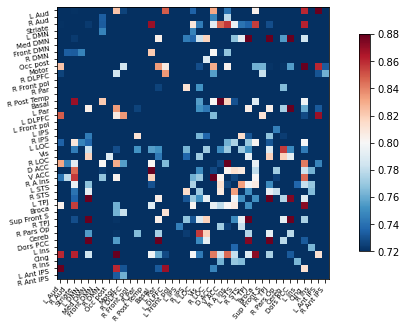

In [18]:
np.fill_diagonal(correlation_matrix,0)
plotting.plot_matrix(correlation_matrix,labels=msdl_atlas.labels, vmax=0.8, vmin=0.8, colorbar=True)

In [21]:

from nilearn.connectome import ConnectivityMeasure
final_x_features = []
for i in range(0, 58, 1):
    roi_time_series = masker.transform(fmri_filenames[i])
    print(ytarget[i])

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]
    np.fill_diagonal(correlation_matrix,0)
    flatmatrix = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k = 1)]
    mean = np.mean(flatmatrix)
    std = np.std(flatmatrix)
    thresholds = [mean, mean - 0.5 * std, mean + 0.5 * std]
    finalmatrix = []
    for threshold in thresholds:
        a = flatmatrix
        a[flatmatrix >= threshold] = 1
        a[flatmatrix < threshold] = 0
        finalmatrix.append(a)

    flatfinalmatrix = [item for sublist in finalmatrix for item in sublist]
    final_x_features.append(flatfinalmatrix)






1
1
1
1
1
2
1
1
2
1
2
1
2
2
2
2
2
2
2
1
1
1
1
1
1
1
2
2
2
2
2
1
2
1
2
1
1
1
2
2
1
2
2
2
2
2
1
1
2
1
2
1
2
2
1
2
1
1


In [22]:
ytarget_np

array([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1])

In [23]:
final_x_features[0]

[1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [29]:
from sklearn import svm
clf = svm.SVC(C=1)
clf.fit(final_x_features[:40], ytarget[:40])

SVC(C=1)

In [32]:
pred_y = clfgs.best_estimator_.predict(final_x_features[40:])
from sklearn import metrics
metrics.accuracy_score(ytarget[40:], pred_y)

0.4444444444444444

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'kernel': ('linear', 'poly', 'rbf'),
    'C': range(1, 10, 1)
}

clfgs = GridSearchCV(clf, parameters)
clfgs.fit(final_x_features[:40], ytarget[:40])
clfgs.best_estimator_

SVC(C=1)

In [49]:
pre

NameError: name 'pre' is not defined

### Next Part(improving)


average correlation
variance
and then make it zero and 1